연습문제 1. Denoise AutoEncoder 구축해보기
==============================
> Denoise AutoEncoder를 구축해봅시다.


In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #생성되는 이미지를 관찰하기 위함입니다. 3차원 플롯을 그리는 용도입니다.
from matplotlib import cm # 데이터포인트에 색상을 입히는 것에 사용됩니다.
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm.auto import tqdm

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", device)

Using Device: cuda


In [2]:
epochs = 10
batch_size = 256
learning_rate = 0.001

In [3]:
dataset = datasets.FashionMNIST(root = './data/', train = True, download = True, transform = transforms.ToTensor())
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
data_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

In [4]:
labels_num = dataset.targets.numpy()
labels = [class_names[i] for i in labels_num]

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Linear(28 * 28, 256), 
            nn.ReLU(),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded) 
        return encoded, decoded

In [6]:
model = Autoencoder().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss() 

In [7]:
# 잡음 더하기
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2 
    # 무작위 작음은 torch.randn() 함수로 만들고 img.size()를 넣어 이미지와 같은 크기의 잡음을 만듭니다.
    # 잡음의 강도는 임의로 0.2로 정했습니다.
    noisy_img = img + noise
    return noisy_img

In [8]:
loss_list = []
for epoch in tqdm(range(1, epochs+1)):
    loss_value = 0
    for step, (x, label) in enumerate(data_loader):
        model.train()
        x = add_noise(x)  # 입력에 노이즈 더하기
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device) 
        label = label.to(device)
        
        encoded, decoded = model(x)
        
        loss = criterion(decoded, y)
        loss_value += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss_value)
    print("Epoch : ", epoch, ', Loss : ', loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :  1 , Loss :  0.08066395670175552
Epoch :  2 , Loss :  0.07580424845218658
Epoch :  3 , Loss :  0.07186819612979889
Epoch :  4 , Loss :  0.07153879106044769
Epoch :  5 , Loss :  0.07314682006835938
Epoch :  6 , Loss :  0.0698806419968605
Epoch :  7 , Loss :  0.06658732891082764
Epoch :  8 , Loss :  0.06712707132101059
Epoch :  9 , Loss :  0.07007068395614624
Epoch :  10 , Loss :  0.06422187387943268


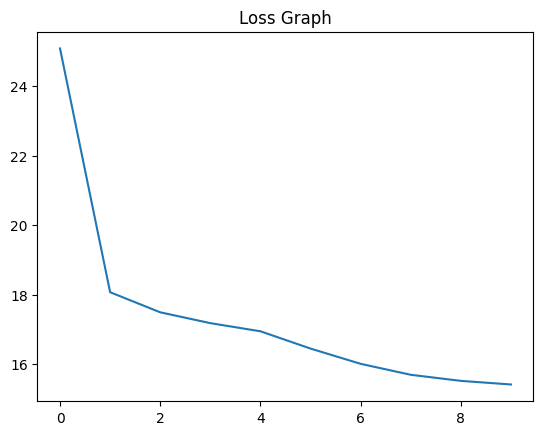

In [9]:
plt.title('Loss Graph')
plt.plot(loss_list)

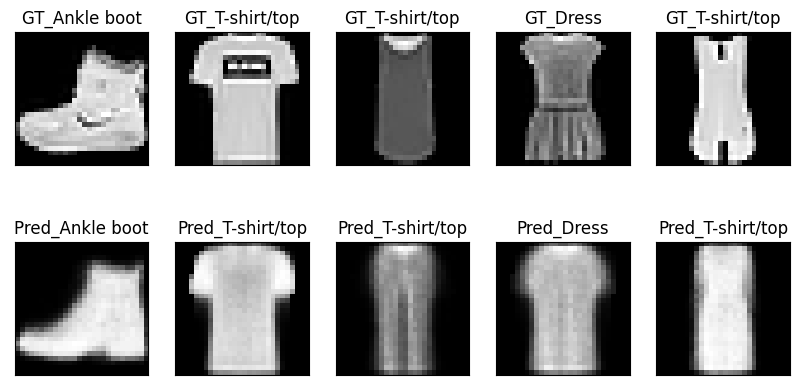

In [11]:
sample_image = dataset.data[:5].view(-1, 28*28)
sample_image = sample_image.type(torch.FloatTensor)/255.
sample_label = dataset.targets[:5]

with torch.no_grad():
    model.eval()
    test_image = sample_image.to(device)
    encode_result, decode_result = model(test_image)

f, a = plt.subplots(2, 5, figsize=(10, 5))


for i in range(5):
    img = np.reshape(sample_image.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
    a[0][i].imshow(img, cmap='gray')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
    a[0][i].set_title('GT_'+class_names[sample_label[i]])

for i in range(5):
    img = np.reshape(decode_result.to("cpu").data.numpy()[i], (28, 28)) 
    # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
    # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
    a[1][i].imshow(img, cmap='gray')
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
    a[1][i].set_title('Pred_'+class_names[sample_label[i]])
plt.show()

In [31]:
idx = 1
testset = datasets.FashionMNIST(root = './data/', train = False, download = True, transform = transforms.ToTensor())
sample_data = testset.data[idx].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.
original_x = sample_data
noisy_x = add_noise(original_x).to(device)
_, recovered_x = model(noisy_x)

In [33]:
testset.data[idx].view(-1, 28*28)

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  13,  67,   0,   0,
           0,   0,  50,  38,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   8, 120, 209, 226, 247, 237, 255,
         255, 255, 247, 238, 235, 172,  72,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0, 137, 239, 252, 243, 234, 229, 238, 244,
         246, 240, 230, 232, 239, 248, 251, 194,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0, 102, 255, 231, 228, 227, 228, 233, 230, 230,
         229, 228, 232, 232, 231, 227, 224, 252, 179,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0, 233, 241, 229, 231, 255, 255, 238, 231, 227,
         238, 246, 228, 230, 227, 234, 235, 229, 241,  20,   0,   0,   0,   0,
           0,   0,   0,   0,   0, 248, 241, 231, 255, 149,  47, 252, 228, 255,
         242, 216, 238, 232, 255, 228, 220, 234, 250,  54,   0,   0,   0,   0,
           0,   0,   0,   0,   0, 255, 240, 232, 255

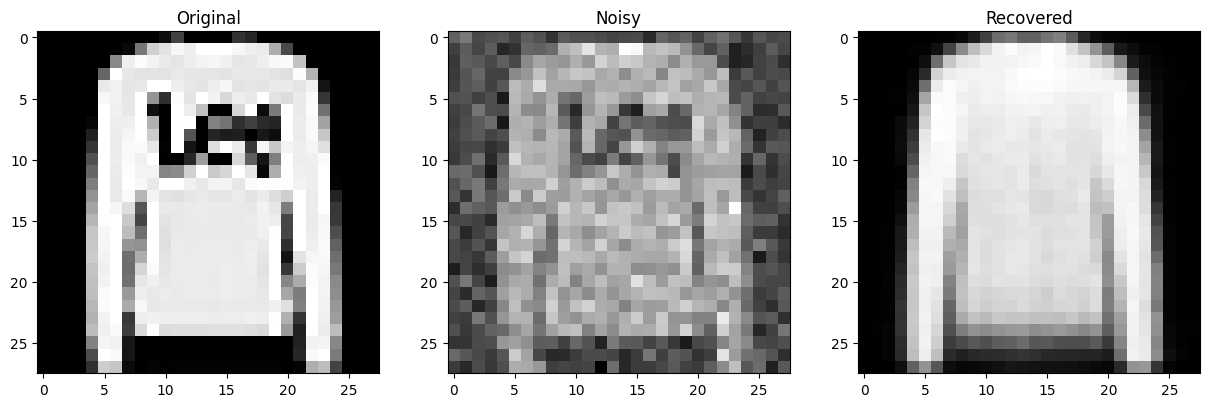

In [34]:
f, a = plt.subplots(1, 3, figsize=(15, 15)) #1행 3열의 표

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()